###  CORTX Metrics Compare Open Source Projects 

This jupyter notebook does some analysis and graphing comparing various open source object storage systems

In [2]:
%%capture
%cd /home/johnbent/cortx/metrics
import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import cortx_community as cc
import cortx_graphing as cg
import datetime
from github import Github

In [3]:
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams.update({'font.size': 22})
plt.rcParams['lines.markersize'] = 10

sf_data=cc.ProjectComparisons().get_stats()
star_data=sf_data['stars']
fork_data=sf_data['forks']

In [6]:
def get_dataframe(data):
    def add_items_to_df(df,name,items):
        df1=pd.DataFrame(data={name : items})
        return pd.concat([df, df1], axis=1) 
    
    largest=0
    name_of_largest = None
    for k,v in data.items():
        if len(v[1]) > largest:
            largest = len(v[1])
            name_of_largest = k
    df=pd.DataFrame(index=data[name_of_largest][0],data={ name_of_largest : data[name_of_largest][1] })
    for k,v in data.items():
        if k is not name_of_largest:
            df=add_items_to_df(df,k,v[1])
    return df

def get_dataframe2(data):
    def add_items_to_df(df,name,items):
        df1=pd.DataFrame(data={name : items})
        return pd.concat([df, df1], axis=1) 
    
    # collect all indices from all data sets
    tmp_indices=set()
    for k,v in data.items():
        tmp_indices |= set(v[0])
    indices=list(sorted(tmp_indices))
    
    # collect all data from all data set using the union of the indices
    all_data={}
    for k,v in data.items():
        data=[]
        for i in indices:
            found = False
            for j in range(len(v[1])):
                if v[0][j] == i:
                    data.append(v[1][j])
                    found = True
            if not found:
                data.append(None)
        all_data[k]=data
    df=pd.DataFrame(index=indices,data=all_data)
    return df.fillna(method='ffill')

def make_graph(df,data,end_day,title,what):
    def get_max_y(data):
        max_y=0
        for k,v in data.items():
            try:
                this_max = v[1][end_day]
            except IndexError:
                this_max = v[1][-1]
            max_y = max(max_y,this_max)
        return max_y * 1.1 # increase it by 10% to add some margin at top of graph

    if end_day:
        max_y=get_max_y(data)
    else:
        max_y=None
    ax=df.plot(xlim=(0,end_day),ylim=(0,max_y),title="%s %s Data" % (title,what))
    ax.set_ylabel('%s Count' % what)
    ax.set_xlabel('Day')
    plt.show()

The next four graphs compare CORTX to a variety of other open source object storage systems.  All graphs normalize the data for each project to each's respective "day zero". Stars are more of a reflection of popularity and marketing whereas forks are a reflection of a much deeper interest in the software.

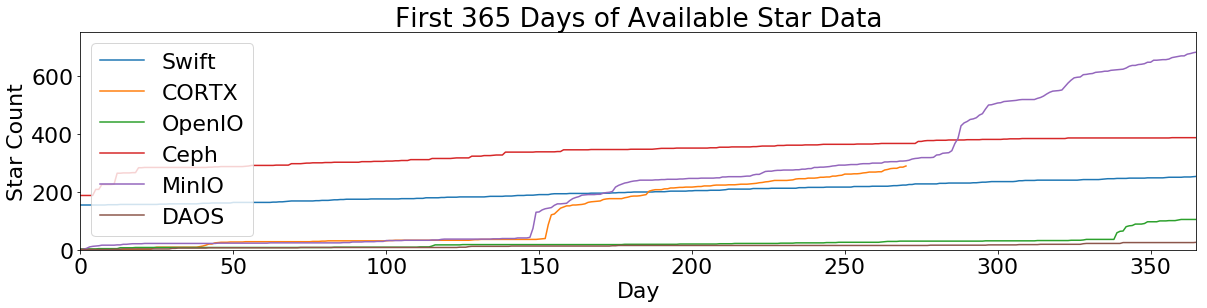

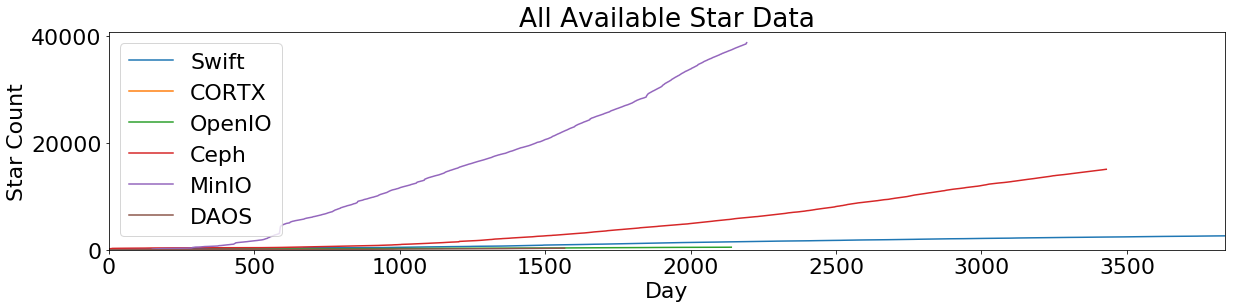

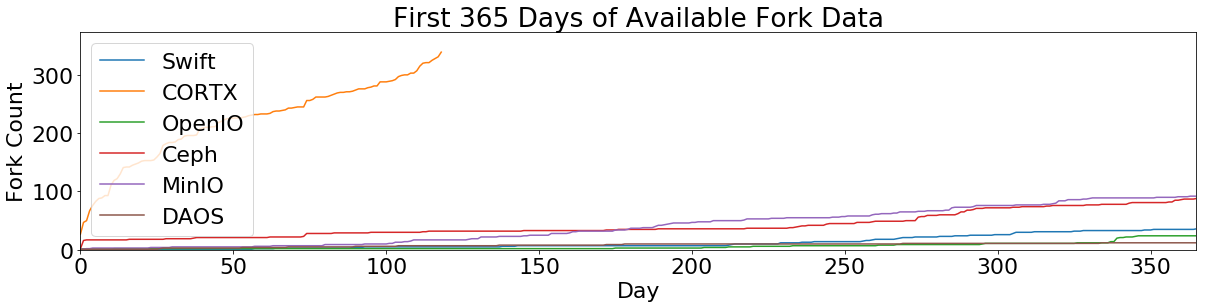

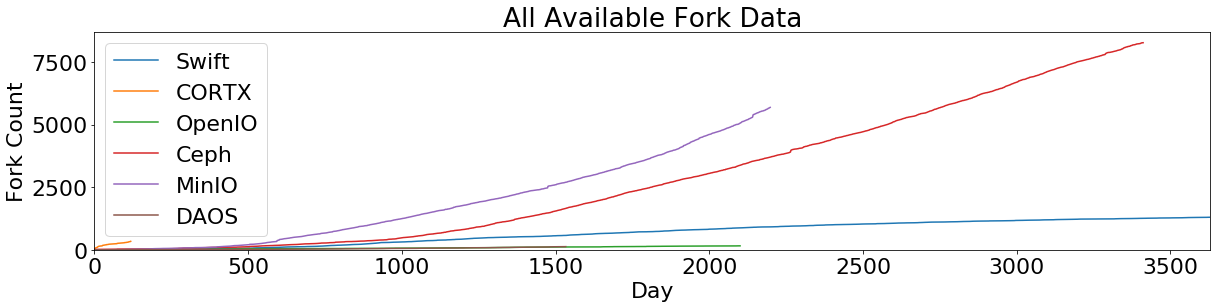

In [7]:
# star graphs
df=get_dataframe(star_data)
make_graph(df=df,data=star_data,end_day=365,title="First 365 Days of Available",what='Star')
make_graph(df=df,data=star_data,end_day=None,title="All Available",what='Star')

# fork graphs
df=get_dataframe(fork_data)
make_graph(df=df,data=fork_data,end_day=365,title="First 365 Days of Available",what='Fork')
make_graph(df=df,data=fork_data,end_day=None,title="All Available",what='Fork')

The graphs below compare each project using absolute dates on the horizontal axis and every scraped metric on the vertical.

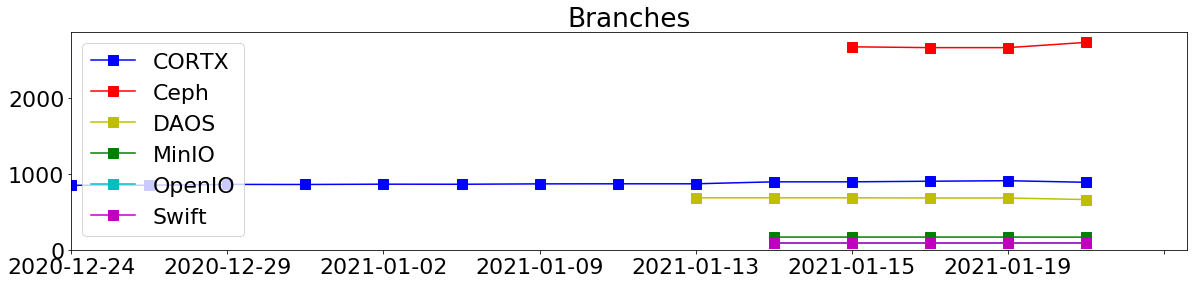

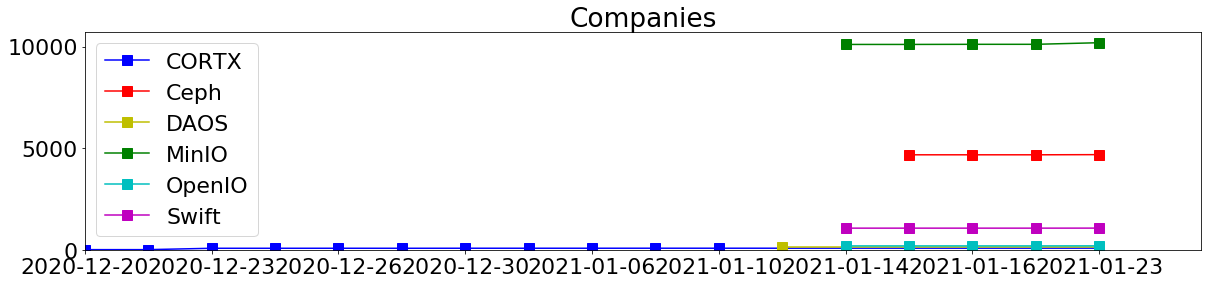

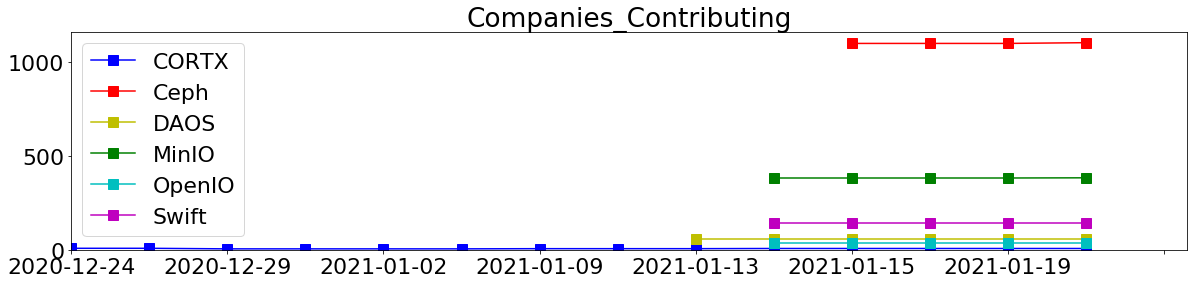

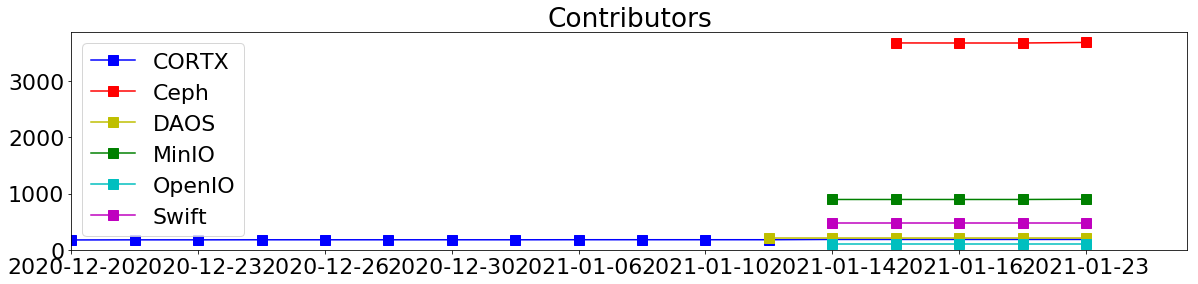

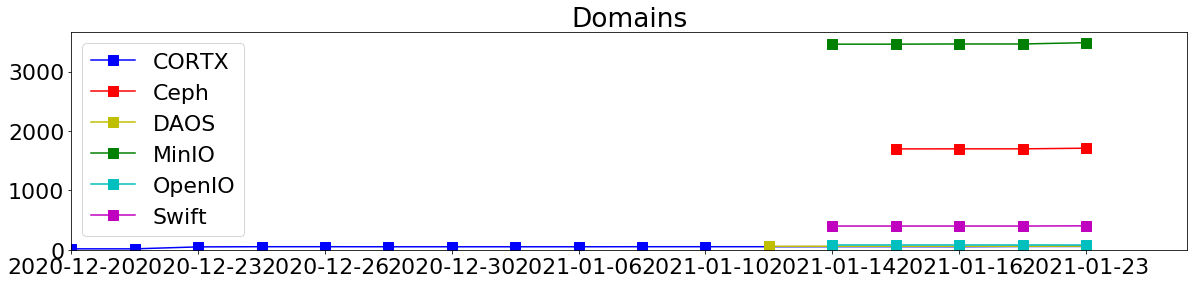

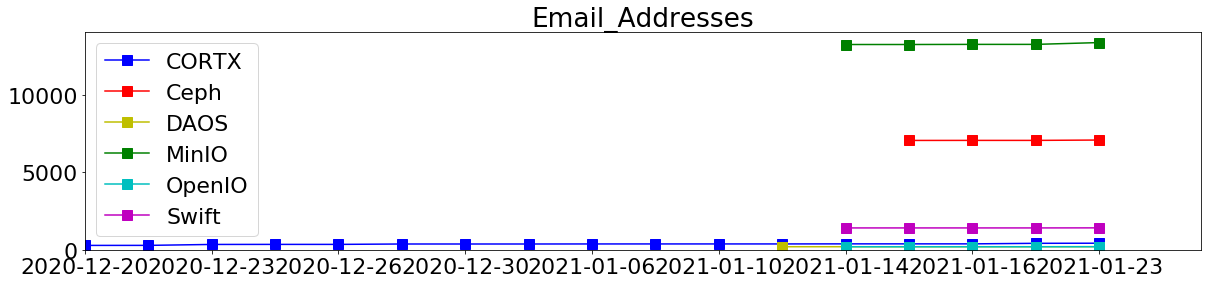

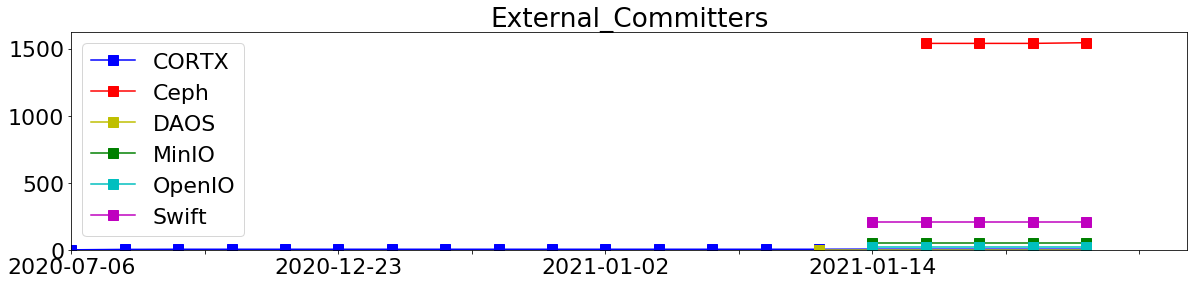

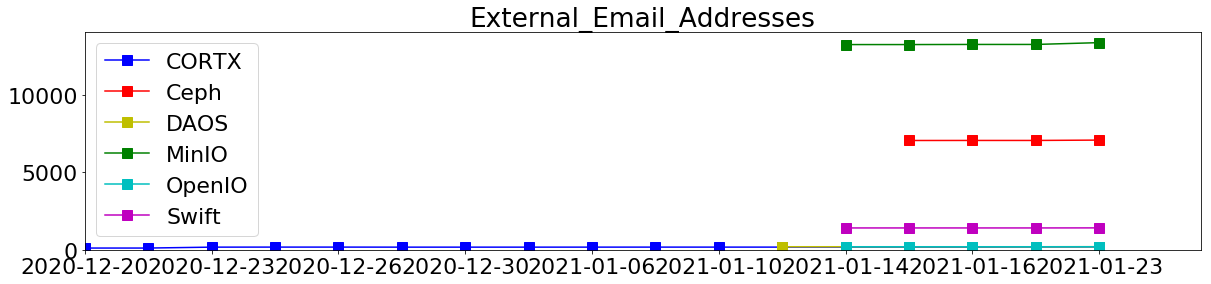

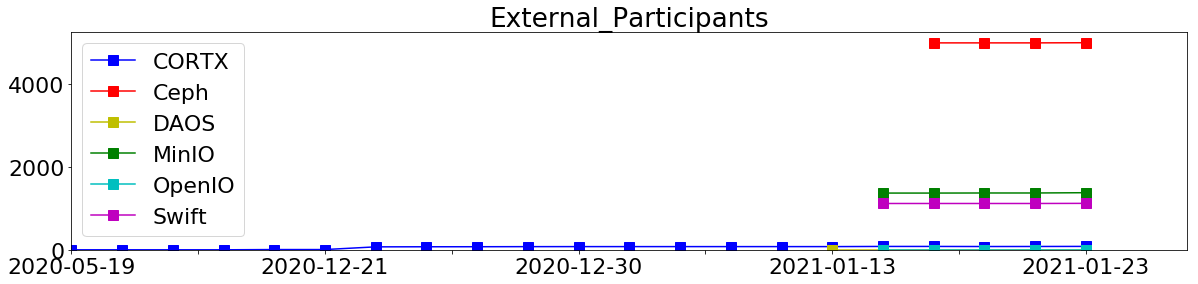

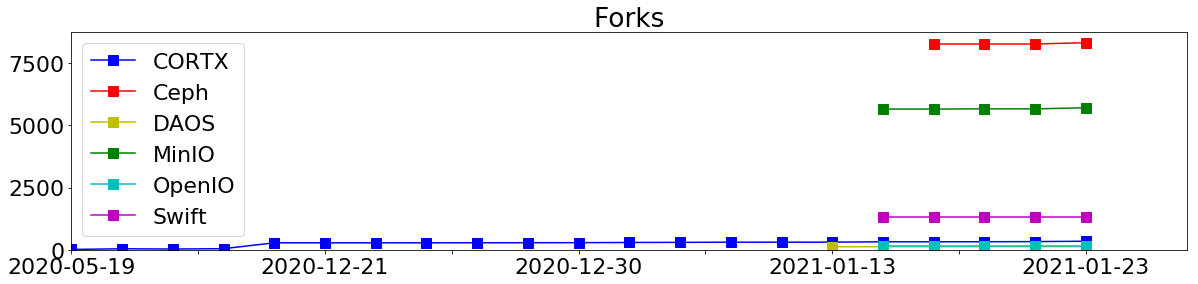

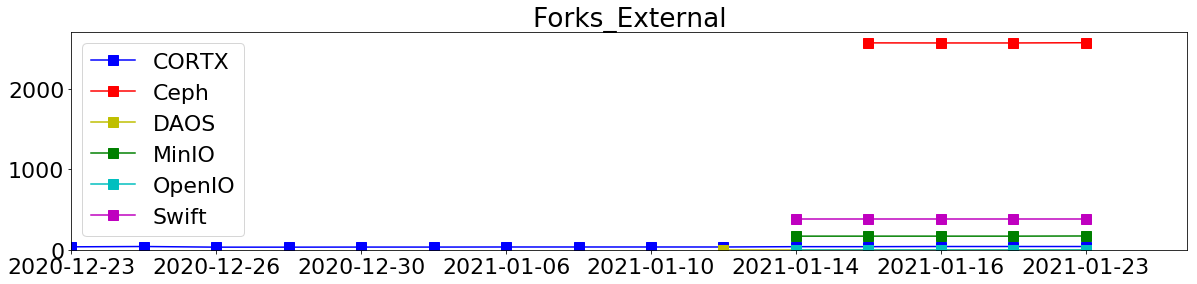

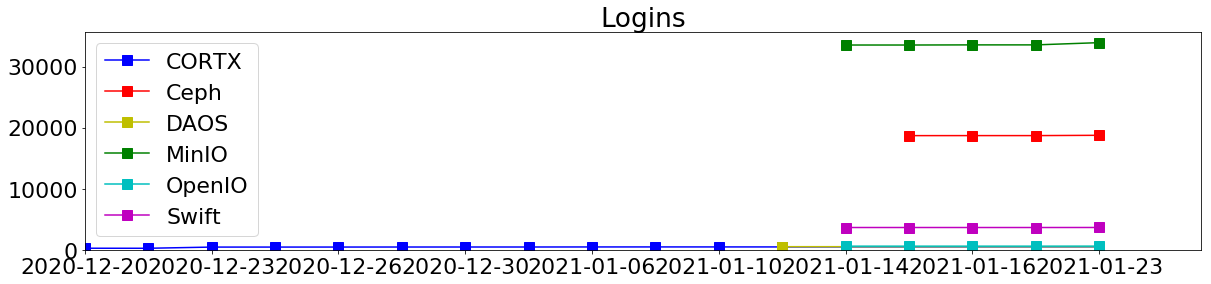

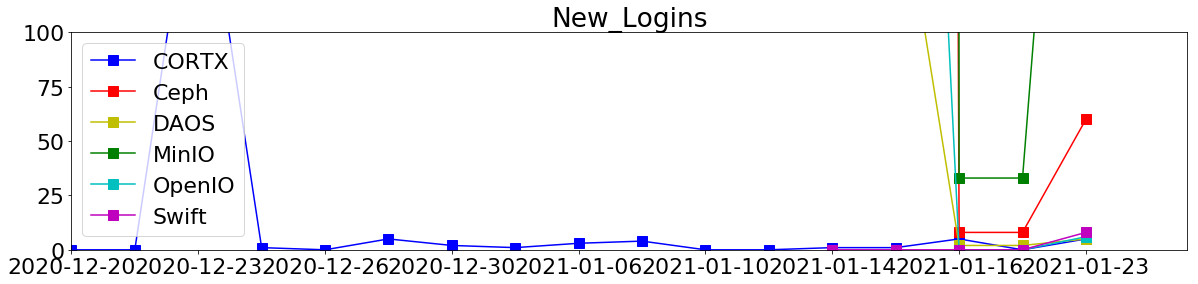

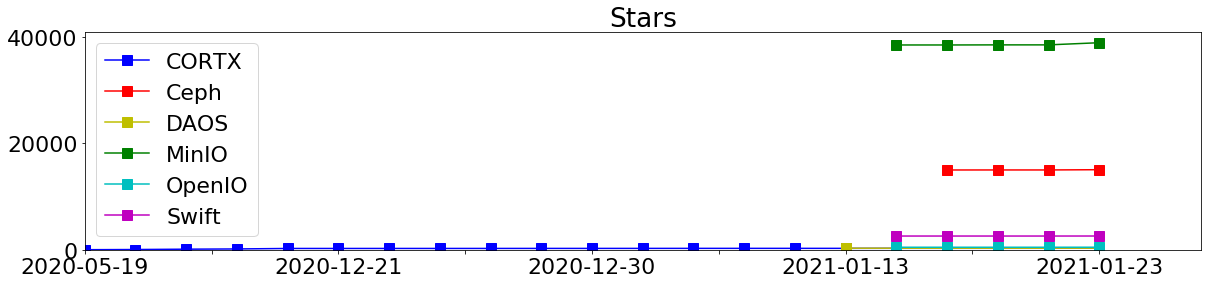

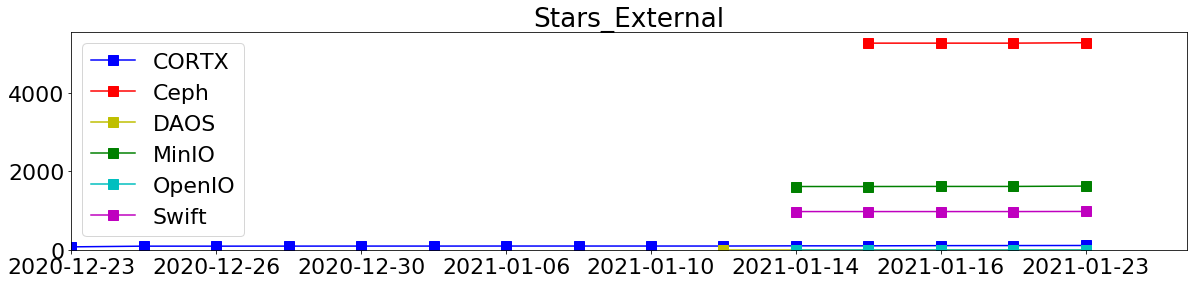

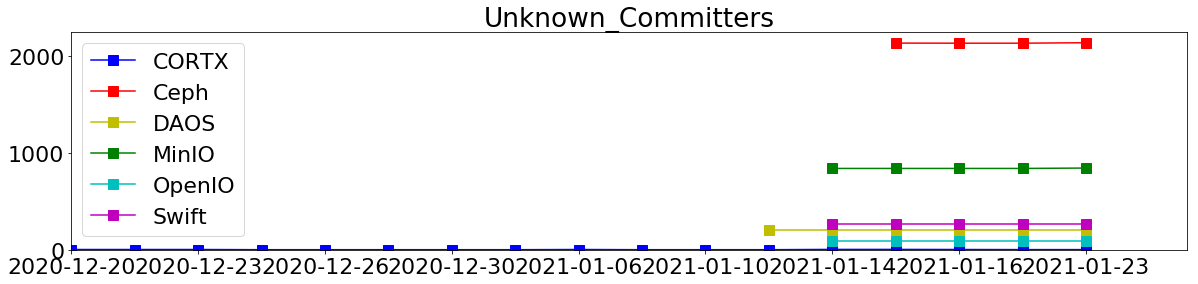

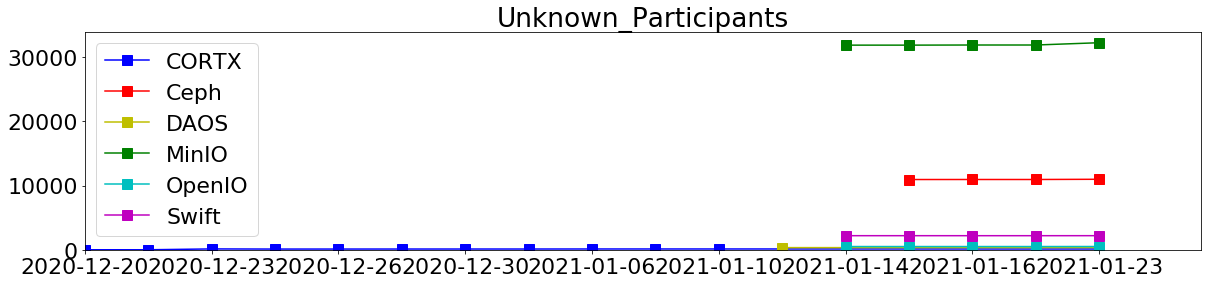

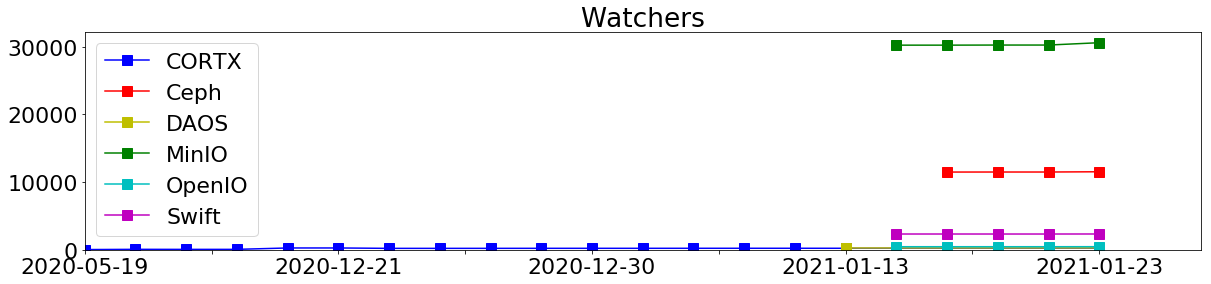

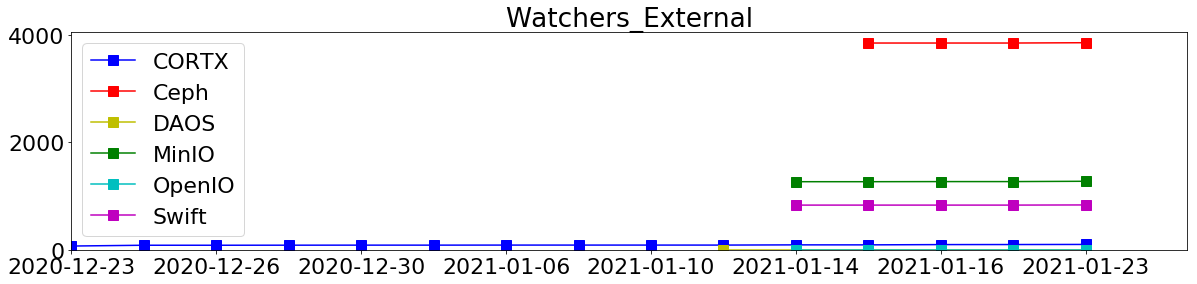

In [10]:
rname='GLOBAL'
def get_dataframe3(stats,key):
    data={}
    for org,values in stats.items():
        dates=[pd.to_datetime(k) for k in values.get_dates(rname)] # this might be better but isn't working...
        dates=values.get_dates(rname)
        values=values.get_values_as_numbers(rname,key)
        data[org]=(dates,values)
    df = get_dataframe2(data)
    df = df.dropna(how='all',axis=0) 
    return df

def org_to_project(org):
    for k,v in cc.projects.items():
        if v[0].lower() == org.lower():
            return k
    return org

# only need this temporarily since some of the projects only have one data point which won't show up with just lines
styles=['bs-', 'rs-', 'ys-','gs-','cs-','ms-','ks-',
        'bo-', 'ro-', 'yo-','go-','co-','mo-','ko-',
        'b^-', 'r^-', 'y^-','g^-','c^-','m^-','k^-',
]

stats={}
for org in cc.org_company_map.keys():
    project_name=org_to_project(org)
    stats[project_name]=cc.PersistentStats(org_name=org)
    if rname not in stats[project_name].get_repos():
        stats.pop(project_name) # haven't scraped for this org yet        
        
def make_graph2(stats,key):
    df=get_dataframe3(stats,key)
    if key == 'new_logins':
        ylim=(0,100)
    else:
        ylim=(0,None)
    ax=df.plot(title=key.title(),ylim=ylim,style=styles)
    (min_x,max_x)=ax.get_xlim()
    max_x *= 1.1 # extend x-axis temporarily since some projects only currently have one datapoint
    plt.xlim(min_x,max_x)
    plt.legend(loc='upper left')
    plt.show()

def get_relevant_keys():
    all_keys=[]
    (dstats,dlatest)=stats['DAOS'].get_latest(rname)
    for k in dstats.keys():
        v = stats['DAOS'].get_values_as_numbers(rname,k)
        if v[-1] > 0:
            all_keys.append(k)
    return sorted(all_keys)

for k in get_relevant_keys():
    make_graph2(stats,k)